In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
from keras.models import Sequential
from keras.layers import Concatenate, concatenate, LSTM, Dense, SimpleRNN, Input, Activation, Dropout
from keras import backend as K
from tensorflow.keras.optimizers import Adam,SGD
import tensorflow as tf
from keras.models import Model
from keras.models import load_model
import time #to calculate the computation time

# Data collection

In [2]:
#system Parameters
T_0 = 300.0
V = 1.0
K0 = 8.46*(np.power(10,6))
Cp = 0.231
rho = 1000.0
F = 5.0
E = 5.0*(np.power(10,4))
Dh = -1.15*(np.power(10,4))
R = 8.314

Q_s = 0.0
CA_0s = 4.0
T1_s = 402.0
CA1_s = 1.95

P = np.array([[1060.0, 22.0], [22.0, 0.52]])

t_final = 0.01  #the control period
t_step = 0.01  # the step to use first-principle to calculate the 

In [3]:
#The data size for new-cstr should be consensus with the basic-one
# generating inputs and initial states for CSTR, all expressed in deviation form

#real value for input
Q1_list = np.linspace(-5e5 * 1.0, 5e5 * 1.0, 5, endpoint=True) #u1
CA0_list = np.linspace(-3.5, 3.5, 5, endpoint=True) #u2

#the initial states are in real value
T1_initial = np.linspace(300.0, 600.0, 80, endpoint=True) - T1_s
CA1_initial = np.linspace(0.0, 6.0, 80, endpoint=True) - CA1_s

print(CA1_initial.shape)
#control variable: Q1, Q2
#state variable: CA1,CA2,CB1,CB2,T1,T2

# sieve out initial states that lie outside of stability region

CA1_start = list()
T1_start = list()


for T1 in T1_initial:   
    for CA1 in CA1_initial:
        x = np.array([CA1, T1])
        if x @ P @ x < 372:
            CA1_start.append(CA1)
            T1_start.append(T1)


# convert to np.arrays
CA1_start = np.array([CA1_start])
T1_start = np.array([T1_start])


x_deviation = np.concatenate((CA1_start.T,T1_start.T), axis=1)  # every row is a pair of initial states within stability region
print("shape of x_deviation is {}".format(x_deviation.shape))
# print(x_deviation.shape)  # the initial state is in

(80,)
shape of x_deviation is (500, 2)


In [4]:
def CSTR_simu(Q1, CA0, t_final, t_step, CA1_initial,T1_initial):
    """
        simulating CSTR using forward Euler method
    """
    CA1_list = list()  # evolution of CA over time
    T1_list = list()  # evolution of T over time
        
    CA1 = CA1_initial + CA1_s  # the real state.the derivation plus the steady state
    T1 = T1_initial + T1_s
    
   
    for i in range(int(t_final / t_step)):
        
        #check the system dynamic

        dCA1 = F/V*(CA0-CA1) - K0*np.exp(-E/(R*(T1)))*CA1
        dT1 = F*(T_0-T1)/V -Dh/(rho*Cp)*K0*np.exp(-E/(R*(T1)))*CA1 + Q1/(rho*Cp*V)
  
        CA1 += dCA1 * t_step
        T1 += dT1 * t_step
        
     
        #if i%5 ==0:
        #the derivative information
        CA1_list.append(dCA1)  # in real value form
        T1_list.append(dT1)  


    return CA1_list, T1_list

In [5]:
# get X and y data for training and testing

CA1_output = list()
T1_output = list()

Q1_input = list()   
CA0_input = list()    #input variable for 
CA1_input = list()
T1_input = list()


for u1 in Q1_list:
    Q1 = u1 + Q_s
    for u2 in CA0_list:
        CA0 = u2 + CA_0s
        for CA1_initial, T1_initial in x_deviation:
            Q1_input.append(Q1 - Q_s)
            CA0_input.append(CA0 - CA_0s)

            CA1_input.append(CA1_initial)
            T1_input.append(T1_initial) #all in deviation form

            CA1_list, T1_list = CSTR_simu(Q1, CA0, t_final, t_step, CA1_initial,T1_initial)

            CA1_output.append(CA1_list) #both in real value
            T1_output.append(T1_list)      

In [6]:
# collate input for RNN

Q1_input = np.array(Q1_input)
Q1_input = Q1_input.reshape(-1,1,1)

CA0_input = np.array(CA0_input)
CA0_input = CA0_input.reshape(-1,1,1)

CA1_input = np.array(CA1_input)
CA1_input = CA1_input.reshape(-1,1,1)

T1_input = np.array(T1_input)
T1_input = T1_input.reshape(-1,1,1)


RNN_input = np.concatenate((CA0_input, Q1_input, CA1_input, T1_input), axis=2)   #the value for input variable and the initial value for state variable 

"""
    the input to RNN is in the shape [number of samples x timestep x variables], and the input variables are same for every
    time step, not sure if my treatment here is correct
"""
print("RNN_input shape is {}".format(RNN_input.shape))
RNN_input = RNN_input.repeat(1, axis=1)  # to keep consensus with the shape for RNN_output, since the output variable is collected 100(0.01/1e-4) times for each RNN_input
print("RNN_input shape is {}".format(RNN_input.shape))

RNN_input shape is (12500, 1, 4)
RNN_input shape is (12500, 1, 4)


In [7]:
# collate output for RNN

CA1_output = np.array(CA1_output)
CA1_output = CA1_output.reshape(-1, 1, 1)


T1_output = np.array(T1_output)
T1_output = T1_output.reshape(-1, 1, 1)


RNN_output = np.concatenate((CA1_output, T1_output), axis=2)
print("RNN_output shape is {}".format(RNN_output.shape))  # output shape: number of samples x timestep x variables

RNN_output shape is (12500, 1, 2)


In [8]:
# split into train and test sets
X_train = RNN_input
y_train = RNN_output

#define scalers for both X and y base on training data only
scaler_X = preprocessing.StandardScaler().fit(X_train.reshape(-1, 4))
scaler_y = preprocessing.StandardScaler().fit(y_train.reshape(-1, 2))


X_train = scaler_X.transform(X_train.reshape(-1, 4)).reshape(-1,1,4)

y_train = scaler_y.transform(y_train.reshape(-1,2)).reshape(-1,1,2)

print(X_train.shape, y_train.shape)

x_train_forPar = X_train[:,:,[2,3]]
y_train_forPar = [y_train,y_train,y_train]

(12500, 1, 4) (12500, 1, 2)


In [9]:
X_train, X_test, y_train, y_test = train_test_split(RNN_input, RNN_output, test_size=0.15, random_state=123)

# define scalers for both X and y base on training data only
scaler_X = preprocessing.StandardScaler().fit(X_train.reshape(-1, 4))
scaler_y = preprocessing.StandardScaler().fit(y_train.reshape(-1, 2))

X_train = scaler_X.transform(X_train.reshape(-1, 4)).reshape(-1,1,4)
y_train = scaler_y.transform(y_train.reshape(-1,2)).reshape(-1,1,2)
X_test = scaler_X.transform(X_test.reshape(-1, 4)).reshape(-1,1,4)
y_test = scaler_y.transform(y_test.reshape(-1,2)).reshape(-1,1,2)
print(X_train.shape, y_train.shape)

x_train_forPar = X_train[:,:,[2,3]]
y_train_forPar = [y_train,y_train,y_train]

x_test_forPar = X_test[:,:,[2,3]]
y_test_forPar = [y_test,y_test,y_test]

(10625, 1, 4) (10625, 1, 2)


# RNN model in control-affine form

In [10]:
#for f
input1 = tf.keras.Input(shape=(1,2))
x1 =  tf.keras.layers.LSTM(8, activation='tanh', return_sequences=True)(input1)
output1 = tf.keras.layers.Dense(2, activation='linear')(x1)

#for g1
x2 =  tf.keras.layers.LSTM(8, activation='tanh', return_sequences=True)(input1)
output2 = tf.keras.layers.Dense(2, activation='linear')(x2)

#for g2
x3 =  tf.keras.layers.LSTM(8, activation='tanh', return_sequences=True)(input1)
output3 = tf.keras.layers.Dense(2, activation='linear')(x3)

model_b = Model(inputs=input1,outputs=[output1, output2, output3])

2025-05-07 17:36:46.217795: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2025-05-07 17:36:46.217823: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (wulab2-System-Product-Name): /proc/driver/nvidia/version does not exist
2025-05-07 17:36:46.218802: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
def custom_mean_squared_error_b(y_pred,y_real):
    
    
    NN_out = model_b(x_train_forPar) # NN_out0: 
    x_state0 = NN_out[0][:,:,0] + NN_out[1][:,:,0] * X_train[:,:,0] #CA   #fx1+gx1*Q 
    x_state1 = NN_out[0][:,:,1] + NN_out[2][:,:,0] * X_train[:,:,1] #T   #fx2+gx2*Ca0

    loss1 = tf.math.reduce_mean((y_train[:,:,0] - x_state0)**2)
    
    loss2 = tf.math.reduce_mean((y_train[:,:,1] - x_state1)**2)

    loss  =  loss1 + loss2
    
    return loss

In [12]:
model_b.compile(optimizer='adam', loss=custom_mean_squared_error_b, metrics=['mse'])
print(model_b.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1, 2)]       0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 1, 8)         352         ['input_1[0][0]']                
                                                                                                  
 lstm_1 (LSTM)                  (None, 1, 8)         352         ['input_1[0][0]']                
                                                                                                  
 lstm_2 (LSTM)                  (None, 1, 8)         352         ['input_1[0][0]']                
                                                                                              

In [13]:
history = model_b.fit(x_train_forPar, y_train_forPar, epochs=300, batch_size=256, validation_split=0.25, verbose=2)

Epoch 1/300
32/32 - 8s - loss: 5.7035 - dense_loss: 1.9012 - dense_1_loss: 1.9012 - dense_2_loss: 1.9012 - dense_mse: 0.9931 - dense_1_mse: 0.9946 - dense_2_mse: 1.0203 - val_loss: 5.2142 - val_dense_loss: 1.7381 - val_dense_1_loss: 1.7381 - val_dense_2_loss: 1.7381 - val_dense_mse: 1.0007 - val_dense_1_mse: 1.0056 - val_dense_2_mse: 1.0365 - 8s/epoch - 264ms/step
Epoch 2/300
32/32 - 1s - loss: 4.7954 - dense_loss: 1.5985 - dense_1_loss: 1.5985 - dense_2_loss: 1.5985 - dense_mse: 0.9880 - dense_1_mse: 0.9969 - dense_2_mse: 1.0330 - val_loss: 4.3254 - val_dense_loss: 1.4418 - val_dense_1_loss: 1.4418 - val_dense_2_loss: 1.4418 - val_dense_mse: 0.9971 - val_dense_1_mse: 1.0127 - val_dense_2_mse: 1.0535 - 949ms/epoch - 30ms/step
Epoch 3/300
32/32 - 1s - loss: 3.9057 - dense_loss: 1.3019 - dense_1_loss: 1.3019 - dense_2_loss: 1.3019 - dense_mse: 0.9843 - dense_1_mse: 1.0103 - dense_2_mse: 1.0561 - val_loss: 3.4350 - val_dense_loss: 1.1450 - val_dense_1_loss: 1.1450 - val_dense_2_loss: 1.14

Epoch 24/300
32/32 - 1s - loss: 0.0063 - dense_loss: 0.0021 - dense_1_loss: 0.0021 - dense_2_loss: 0.0021 - dense_mse: 0.9597 - dense_1_mse: 1.4669 - dense_2_mse: 1.5683 - val_loss: 0.0059 - val_dense_loss: 0.0020 - val_dense_1_loss: 0.0020 - val_dense_2_loss: 0.0020 - val_dense_mse: 0.9757 - val_dense_1_mse: 1.4655 - val_dense_2_mse: 1.5658 - 973ms/epoch - 30ms/step
Epoch 25/300
32/32 - 1s - loss: 0.0056 - dense_loss: 0.0019 - dense_1_loss: 0.0019 - dense_2_loss: 0.0019 - dense_mse: 0.9596 - dense_1_mse: 1.4678 - dense_2_mse: 1.5693 - val_loss: 0.0053 - val_dense_loss: 0.0018 - val_dense_1_loss: 0.0018 - val_dense_2_loss: 0.0018 - val_dense_mse: 0.9757 - val_dense_1_mse: 1.4662 - val_dense_2_mse: 1.5665 - 979ms/epoch - 31ms/step
Epoch 26/300
32/32 - 1s - loss: 0.0050 - dense_loss: 0.0017 - dense_1_loss: 0.0017 - dense_2_loss: 0.0017 - dense_mse: 0.9596 - dense_1_mse: 1.4685 - dense_2_mse: 1.5700 - val_loss: 0.0048 - val_dense_loss: 0.0016 - val_dense_1_loss: 0.0016 - val_dense_2_loss:

Epoch 46/300
32/32 - 1s - loss: 0.0014 - dense_loss: 4.7596e-04 - dense_1_loss: 4.7596e-04 - dense_2_loss: 4.7596e-04 - dense_mse: 0.9593 - dense_1_mse: 1.4719 - dense_2_mse: 1.5695 - val_loss: 0.0014 - val_dense_loss: 4.6316e-04 - val_dense_1_loss: 4.6316e-04 - val_dense_2_loss: 4.6316e-04 - val_dense_mse: 0.9755 - val_dense_1_mse: 1.4696 - val_dense_2_mse: 1.5663 - 978ms/epoch - 31ms/step
Epoch 47/300
32/32 - 1s - loss: 0.0014 - dense_loss: 4.5236e-04 - dense_1_loss: 4.5236e-04 - dense_2_loss: 4.5236e-04 - dense_mse: 0.9593 - dense_1_mse: 1.4720 - dense_2_mse: 1.5694 - val_loss: 0.0013 - val_dense_loss: 4.4053e-04 - val_dense_1_loss: 4.4053e-04 - val_dense_2_loss: 4.4053e-04 - val_dense_mse: 0.9754 - val_dense_1_mse: 1.4697 - val_dense_2_mse: 1.5663 - 982ms/epoch - 31ms/step
Epoch 48/300
32/32 - 1s - loss: 0.0013 - dense_loss: 4.3054e-04 - dense_1_loss: 4.3054e-04 - dense_2_loss: 4.3054e-04 - dense_mse: 0.9593 - dense_1_mse: 1.4721 - dense_2_mse: 1.5693 - val_loss: 0.0013 - val_dense

Epoch 67/300
32/32 - 1s - loss: 6.4410e-04 - dense_loss: 2.1470e-04 - dense_1_loss: 2.1470e-04 - dense_2_loss: 2.1470e-04 - dense_mse: 0.9593 - dense_1_mse: 1.4732 - dense_2_mse: 1.5674 - val_loss: 6.3475e-04 - val_dense_loss: 2.1158e-04 - val_dense_1_loss: 2.1158e-04 - val_dense_2_loss: 2.1158e-04 - val_dense_mse: 0.9753 - val_dense_1_mse: 1.4709 - val_dense_2_mse: 1.5645 - 949ms/epoch - 30ms/step
Epoch 68/300
32/32 - 1s - loss: 6.2669e-04 - dense_loss: 2.0890e-04 - dense_1_loss: 2.0890e-04 - dense_2_loss: 2.0890e-04 - dense_mse: 0.9593 - dense_1_mse: 1.4732 - dense_2_mse: 1.5673 - val_loss: 6.1777e-04 - val_dense_loss: 2.0592e-04 - val_dense_1_loss: 2.0592e-04 - val_dense_2_loss: 2.0592e-04 - val_dense_mse: 0.9753 - val_dense_1_mse: 1.4710 - val_dense_2_mse: 1.5644 - 958ms/epoch - 30ms/step
Epoch 69/300
32/32 - 1s - loss: 6.1006e-04 - dense_loss: 2.0335e-04 - dense_1_loss: 2.0335e-04 - dense_2_loss: 2.0335e-04 - dense_mse: 0.9593 - dense_1_mse: 1.4733 - dense_2_mse: 1.5672 - val_loss

Epoch 88/300
32/32 - 1s - loss: 3.8287e-04 - dense_loss: 1.2762e-04 - dense_1_loss: 1.2762e-04 - dense_2_loss: 1.2762e-04 - dense_mse: 0.9593 - dense_1_mse: 1.4741 - dense_2_mse: 1.5651 - val_loss: 3.7811e-04 - val_dense_loss: 1.2604e-04 - val_dense_1_loss: 1.2604e-04 - val_dense_2_loss: 1.2604e-04 - val_dense_mse: 0.9752 - val_dense_1_mse: 1.4720 - val_dense_2_mse: 1.5622 - 948ms/epoch - 30ms/step
Epoch 89/300
32/32 - 1s - loss: 3.7395e-04 - dense_loss: 1.2465e-04 - dense_1_loss: 1.2465e-04 - dense_2_loss: 1.2465e-04 - dense_mse: 0.9593 - dense_1_mse: 1.4742 - dense_2_mse: 1.5650 - val_loss: 3.6932e-04 - val_dense_loss: 1.2311e-04 - val_dense_1_loss: 1.2311e-04 - val_dense_2_loss: 1.2311e-04 - val_dense_mse: 0.9752 - val_dense_1_mse: 1.4720 - val_dense_2_mse: 1.5621 - 944ms/epoch - 30ms/step
Epoch 90/300
32/32 - 1s - loss: 3.6526e-04 - dense_loss: 1.2175e-04 - dense_1_loss: 1.2175e-04 - dense_2_loss: 1.2175e-04 - dense_mse: 0.9593 - dense_1_mse: 1.4742 - dense_2_mse: 1.5649 - val_loss

Epoch 109/300
32/32 - 1s - loss: 2.3578e-04 - dense_loss: 7.8594e-05 - dense_1_loss: 7.8594e-05 - dense_2_loss: 7.8594e-05 - dense_mse: 0.9592 - dense_1_mse: 1.4748 - dense_2_mse: 1.5626 - val_loss: 2.3301e-04 - val_dense_loss: 7.7669e-05 - val_dense_1_loss: 7.7669e-05 - val_dense_2_loss: 7.7669e-05 - val_dense_mse: 0.9752 - val_dense_1_mse: 1.4727 - val_dense_2_mse: 1.5599 - 957ms/epoch - 30ms/step
Epoch 110/300
32/32 - 1s - loss: 2.3058e-04 - dense_loss: 7.6861e-05 - dense_1_loss: 7.6861e-05 - dense_2_loss: 7.6861e-05 - dense_mse: 0.9592 - dense_1_mse: 1.4748 - dense_2_mse: 1.5625 - val_loss: 2.2789e-04 - val_dense_loss: 7.5963e-05 - val_dense_1_loss: 7.5963e-05 - val_dense_2_loss: 7.5963e-05 - val_dense_mse: 0.9752 - val_dense_1_mse: 1.4727 - val_dense_2_mse: 1.5598 - 954ms/epoch - 30ms/step
Epoch 111/300
32/32 - 1s - loss: 2.2554e-04 - dense_loss: 7.5179e-05 - dense_1_loss: 7.5179e-05 - dense_2_loss: 7.5179e-05 - dense_mse: 0.9592 - dense_1_mse: 1.4748 - dense_2_mse: 1.5624 - val_l

Epoch 130/300
32/32 - 1s - loss: 1.5282e-04 - dense_loss: 5.0941e-05 - dense_1_loss: 5.0941e-05 - dense_2_loss: 5.0941e-05 - dense_mse: 0.9592 - dense_1_mse: 1.4752 - dense_2_mse: 1.5602 - val_loss: 1.5128e-04 - val_dense_loss: 5.0428e-05 - val_dense_1_loss: 5.0428e-05 - val_dense_2_loss: 5.0428e-05 - val_dense_mse: 0.9751 - val_dense_1_mse: 1.4731 - val_dense_2_mse: 1.5576 - 950ms/epoch - 30ms/step
Epoch 131/300
32/32 - 1s - loss: 1.4996e-04 - dense_loss: 4.9986e-05 - dense_1_loss: 4.9986e-05 - dense_2_loss: 4.9986e-05 - dense_mse: 0.9592 - dense_1_mse: 1.4752 - dense_2_mse: 1.5601 - val_loss: 1.4847e-04 - val_dense_loss: 4.9490e-05 - val_dense_1_loss: 4.9490e-05 - val_dense_2_loss: 4.9490e-05 - val_dense_mse: 0.9751 - val_dense_1_mse: 1.4732 - val_dense_2_mse: 1.5575 - 963ms/epoch - 30ms/step
Epoch 132/300
32/32 - 1s - loss: 1.4717e-04 - dense_loss: 4.9058e-05 - dense_1_loss: 4.9058e-05 - dense_2_loss: 4.9058e-05 - dense_mse: 0.9592 - dense_1_mse: 1.4753 - dense_2_mse: 1.5600 - val_l

Epoch 151/300
32/32 - 1s - loss: 1.0457e-04 - dense_loss: 3.4857e-05 - dense_1_loss: 3.4857e-05 - dense_2_loss: 3.4857e-05 - dense_mse: 0.9592 - dense_1_mse: 1.4755 - dense_2_mse: 1.5581 - val_loss: 1.0357e-04 - val_dense_loss: 3.4525e-05 - val_dense_1_loss: 3.4525e-05 - val_dense_2_loss: 3.4525e-05 - val_dense_mse: 0.9751 - val_dense_1_mse: 1.4735 - val_dense_2_mse: 1.5556 - 1s/epoch - 32ms/step
Epoch 152/300
32/32 - 1s - loss: 1.0270e-04 - dense_loss: 3.4234e-05 - dense_1_loss: 3.4234e-05 - dense_2_loss: 3.4234e-05 - dense_mse: 0.9592 - dense_1_mse: 1.4756 - dense_2_mse: 1.5580 - val_loss: 1.0173e-04 - val_dense_loss: 3.3910e-05 - val_dense_1_loss: 3.3910e-05 - val_dense_2_loss: 3.3910e-05 - val_dense_mse: 0.9751 - val_dense_1_mse: 1.4735 - val_dense_2_mse: 1.5555 - 957ms/epoch - 30ms/step
Epoch 153/300
32/32 - 1s - loss: 1.0087e-04 - dense_loss: 3.3625e-05 - dense_1_loss: 3.3625e-05 - dense_2_loss: 3.3625e-05 - dense_mse: 0.9592 - dense_1_mse: 1.4756 - dense_2_mse: 1.5579 - val_loss

Epoch 172/300
32/32 - 1s - loss: 7.1137e-05 - dense_loss: 2.3712e-05 - dense_1_loss: 2.3712e-05 - dense_2_loss: 2.3712e-05 - dense_mse: 0.9592 - dense_1_mse: 1.4758 - dense_2_mse: 1.5564 - val_loss: 7.0434e-05 - val_dense_loss: 2.3478e-05 - val_dense_1_loss: 2.3478e-05 - val_dense_2_loss: 2.3478e-05 - val_dense_mse: 0.9751 - val_dense_1_mse: 1.4738 - val_dense_2_mse: 1.5538 - 951ms/epoch - 30ms/step
Epoch 173/300
32/32 - 1s - loss: 6.9814e-05 - dense_loss: 2.3271e-05 - dense_1_loss: 2.3271e-05 - dense_2_loss: 2.3271e-05 - dense_mse: 0.9592 - dense_1_mse: 1.4758 - dense_2_mse: 1.5563 - val_loss: 6.9121e-05 - val_dense_loss: 2.3040e-05 - val_dense_1_loss: 2.3040e-05 - val_dense_2_loss: 2.3040e-05 - val_dense_mse: 0.9751 - val_dense_1_mse: 1.4738 - val_dense_2_mse: 1.5538 - 959ms/epoch - 30ms/step
Epoch 174/300
32/32 - 1s - loss: 6.8510e-05 - dense_loss: 2.2837e-05 - dense_1_loss: 2.2837e-05 - dense_2_loss: 2.2837e-05 - dense_mse: 0.9592 - dense_1_mse: 1.4758 - dense_2_mse: 1.5562 - val_l

Epoch 193/300
32/32 - 1s - loss: 4.8158e-05 - dense_loss: 1.6053e-05 - dense_1_loss: 1.6053e-05 - dense_2_loss: 1.6053e-05 - dense_mse: 0.9592 - dense_1_mse: 1.4760 - dense_2_mse: 1.5550 - val_loss: 4.7722e-05 - val_dense_loss: 1.5907e-05 - val_dense_1_loss: 1.5907e-05 - val_dense_2_loss: 1.5907e-05 - val_dense_mse: 0.9750 - val_dense_1_mse: 1.4740 - val_dense_2_mse: 1.5526 - 951ms/epoch - 30ms/step
Epoch 194/300
32/32 - 1s - loss: 4.7869e-05 - dense_loss: 1.5956e-05 - dense_1_loss: 1.5956e-05 - dense_2_loss: 1.5956e-05 - dense_mse: 0.9592 - dense_1_mse: 1.4760 - dense_2_mse: 1.5550 - val_loss: 4.6954e-05 - val_dense_loss: 1.5651e-05 - val_dense_1_loss: 1.5651e-05 - val_dense_2_loss: 1.5651e-05 - val_dense_mse: 0.9750 - val_dense_1_mse: 1.4740 - val_dense_2_mse: 1.5525 - 954ms/epoch - 30ms/step
Epoch 195/300
32/32 - 1s - loss: 4.6490e-05 - dense_loss: 1.5497e-05 - dense_1_loss: 1.5497e-05 - dense_2_loss: 1.5497e-05 - dense_mse: 0.9592 - dense_1_mse: 1.4760 - dense_2_mse: 1.5549 - val_l

Epoch 214/300
32/32 - 1s - loss: 3.4583e-05 - dense_loss: 1.1528e-05 - dense_1_loss: 1.1528e-05 - dense_2_loss: 1.1528e-05 - dense_mse: 0.9592 - dense_1_mse: 1.4761 - dense_2_mse: 1.5542 - val_loss: 3.3256e-05 - val_dense_loss: 1.1085e-05 - val_dense_1_loss: 1.1085e-05 - val_dense_2_loss: 1.1085e-05 - val_dense_mse: 0.9750 - val_dense_1_mse: 1.4742 - val_dense_2_mse: 1.5517 - 980ms/epoch - 31ms/step
Epoch 215/300
32/32 - 1s - loss: 3.3066e-05 - dense_loss: 1.1022e-05 - dense_1_loss: 1.1022e-05 - dense_2_loss: 1.1022e-05 - dense_mse: 0.9592 - dense_1_mse: 1.4761 - dense_2_mse: 1.5541 - val_loss: 3.2754e-05 - val_dense_loss: 1.0918e-05 - val_dense_1_loss: 1.0918e-05 - val_dense_2_loss: 1.0918e-05 - val_dense_mse: 0.9750 - val_dense_1_mse: 1.4742 - val_dense_2_mse: 1.5517 - 965ms/epoch - 30ms/step
Epoch 216/300
32/32 - 1s - loss: 3.2503e-05 - dense_loss: 1.0834e-05 - dense_1_loss: 1.0834e-05 - dense_2_loss: 1.0834e-05 - dense_mse: 0.9592 - dense_1_mse: 1.4761 - dense_2_mse: 1.5541 - val_l

Epoch 235/300
32/32 - 1s - loss: 2.4712e-05 - dense_loss: 8.2374e-06 - dense_1_loss: 8.2374e-06 - dense_2_loss: 8.2374e-06 - dense_mse: 0.9592 - dense_1_mse: 1.4762 - dense_2_mse: 1.5538 - val_loss: 2.8637e-05 - val_dense_loss: 9.5456e-06 - val_dense_1_loss: 9.5456e-06 - val_dense_2_loss: 9.5456e-06 - val_dense_mse: 0.9750 - val_dense_1_mse: 1.4743 - val_dense_2_mse: 1.5515 - 1s/epoch - 33ms/step
Epoch 236/300
32/32 - 1s - loss: 2.5334e-05 - dense_loss: 8.4447e-06 - dense_1_loss: 8.4447e-06 - dense_2_loss: 8.4447e-06 - dense_mse: 0.9592 - dense_1_mse: 1.4762 - dense_2_mse: 1.5538 - val_loss: 2.4180e-05 - val_dense_loss: 8.0600e-06 - val_dense_1_loss: 8.0600e-06 - val_dense_2_loss: 8.0600e-06 - val_dense_mse: 0.9750 - val_dense_1_mse: 1.4743 - val_dense_2_mse: 1.5515 - 1s/epoch - 36ms/step
Epoch 237/300
32/32 - 1s - loss: 2.3910e-05 - dense_loss: 7.9699e-06 - dense_1_loss: 7.9699e-06 - dense_2_loss: 7.9699e-06 - dense_mse: 0.9592 - dense_1_mse: 1.4762 - dense_2_mse: 1.5538 - val_loss: 2

Epoch 256/300
32/32 - 1s - loss: 1.8824e-05 - dense_loss: 6.2748e-06 - dense_1_loss: 6.2748e-06 - dense_2_loss: 6.2748e-06 - dense_mse: 0.9592 - dense_1_mse: 1.4762 - dense_2_mse: 1.5540 - val_loss: 1.8706e-05 - val_dense_loss: 6.2354e-06 - val_dense_1_loss: 6.2354e-06 - val_dense_2_loss: 6.2354e-06 - val_dense_mse: 0.9750 - val_dense_1_mse: 1.4744 - val_dense_2_mse: 1.5517 - 1s/epoch - 35ms/step
Epoch 257/300
32/32 - 1s - loss: 1.9699e-05 - dense_loss: 6.5665e-06 - dense_1_loss: 6.5665e-06 - dense_2_loss: 6.5665e-06 - dense_mse: 0.9592 - dense_1_mse: 1.4762 - dense_2_mse: 1.5540 - val_loss: 1.9647e-05 - val_dense_loss: 6.5490e-06 - val_dense_1_loss: 6.5490e-06 - val_dense_2_loss: 6.5490e-06 - val_dense_mse: 0.9750 - val_dense_1_mse: 1.4744 - val_dense_2_mse: 1.5517 - 1s/epoch - 34ms/step
Epoch 258/300
32/32 - 1s - loss: 1.8657e-05 - dense_loss: 6.2189e-06 - dense_1_loss: 6.2189e-06 - dense_2_loss: 6.2189e-06 - dense_mse: 0.9592 - dense_1_mse: 1.4762 - dense_2_mse: 1.5541 - val_loss: 1

Epoch 277/300
32/32 - 1s - loss: 1.5027e-05 - dense_loss: 5.0090e-06 - dense_1_loss: 5.0090e-06 - dense_2_loss: 5.0090e-06 - dense_mse: 0.9592 - dense_1_mse: 1.4763 - dense_2_mse: 1.5546 - val_loss: 1.5287e-05 - val_dense_loss: 5.0957e-06 - val_dense_1_loss: 5.0957e-06 - val_dense_2_loss: 5.0957e-06 - val_dense_mse: 0.9750 - val_dense_1_mse: 1.4744 - val_dense_2_mse: 1.5523 - 979ms/epoch - 31ms/step
Epoch 278/300
32/32 - 1s - loss: 1.6471e-05 - dense_loss: 5.4903e-06 - dense_1_loss: 5.4903e-06 - dense_2_loss: 5.4903e-06 - dense_mse: 0.9592 - dense_1_mse: 1.4763 - dense_2_mse: 1.5547 - val_loss: 1.5222e-05 - val_dense_loss: 5.0739e-06 - val_dense_1_loss: 5.0739e-06 - val_dense_2_loss: 5.0739e-06 - val_dense_mse: 0.9750 - val_dense_1_mse: 1.4744 - val_dense_2_mse: 1.5523 - 1s/epoch - 33ms/step
Epoch 279/300
32/32 - 1s - loss: 1.4797e-05 - dense_loss: 4.9322e-06 - dense_1_loss: 4.9322e-06 - dense_2_loss: 4.9322e-06 - dense_mse: 0.9592 - dense_1_mse: 1.4763 - dense_2_mse: 1.5547 - val_loss

Epoch 298/300
32/32 - 1s - loss: 1.2399e-05 - dense_loss: 4.1332e-06 - dense_1_loss: 4.1332e-06 - dense_2_loss: 4.1332e-06 - dense_mse: 0.9592 - dense_1_mse: 1.4763 - dense_2_mse: 1.5555 - val_loss: 1.2344e-05 - val_dense_loss: 4.1146e-06 - val_dense_1_loss: 4.1146e-06 - val_dense_2_loss: 4.1146e-06 - val_dense_mse: 0.9750 - val_dense_1_mse: 1.4745 - val_dense_2_mse: 1.5532 - 1s/epoch - 31ms/step
Epoch 299/300
32/32 - 1s - loss: 1.2295e-05 - dense_loss: 4.0982e-06 - dense_1_loss: 4.0982e-06 - dense_2_loss: 4.0982e-06 - dense_mse: 0.9592 - dense_1_mse: 1.4763 - dense_2_mse: 1.5556 - val_loss: 1.2239e-05 - val_dense_loss: 4.0798e-06 - val_dense_1_loss: 4.0798e-06 - val_dense_2_loss: 4.0798e-06 - val_dense_mse: 0.9750 - val_dense_1_mse: 1.4745 - val_dense_2_mse: 1.5532 - 1s/epoch - 35ms/step
Epoch 300/300
32/32 - 1s - loss: 1.2190e-05 - dense_loss: 4.0635e-06 - dense_1_loss: 4.0635e-06 - dense_2_loss: 4.0635e-06 - dense_mse: 0.9592 - dense_1_mse: 1.4763 - dense_2_mse: 1.5556 - val_loss: 1

In [14]:
model_b.save_weights("CSTR_LSTM")
#model_b.load_weights("CSTR_RNN")

# Model test and prediction performance

In [15]:
NN_out = model_b(x_test_forPar) # NN_out0: 
x_state0 = NN_out[0][:,:,0] + NN_out[1][:,:,0] * X_test[:,:,0] #CA   #fx1+gx1*Q 
x_state1 = NN_out[0][:,:,1] + NN_out[2][:,:,0] * X_test[:,:,1] #T   #fx2+gx2*Ca0

loss1 = tf.math.reduce_mean((y_test[:,:,0] - x_state0)**2)

loss2 = tf.math.reduce_mean((y_test[:,:,1] - x_state1)**2)

loss  =  loss1 + loss2

print(loss)

tf.Tensor(3.893914e-06, shape=(), dtype=float32)


In [16]:
print(scaler_X.mean_)
print(scaler_X.scale_)

print(scaler_y.mean_)
print(scaler_y.scale_)

[ 9.05882353e-03  9.17647059e+02  4.49709605e-03 -2.09084140e-02]
[2.47561406e+00 3.53760112e+05 8.51755269e-01 3.83968501e+01]
[   4.15243004 -201.228787  ]
[  12.81818325 1536.18948734]


In [17]:
#10*10*10*10
state_mean = np.array([4.49709605e-03, -2.09084140e-02])
state_std = np.array([8.51755269e-01, 3.83968501e+01]) # for x initial

dx1_mean = 4.15243004 
dx1_std =   12.81818325 

dx2_mean = -201.228787 # for \dot x
dx2_std = 1536.18948734



u1_mean = 9.05882353e-03    #CA0
u1_std = 2.47561406e+00 

u2_mean = 9.17647059e+02 #Q
u2_std = 3.53760112e+05 

In [18]:
#get fx and gx
def my_ens_prediction(my_rawdata): #my_rawdata: current T,CA,CB; return:  real value of f(x) and g(x)
    
    NUM_IN_SEQUENCE = 1 #RNN中一组数据对应的时序
    NUM_INPUTS = 2
    
    #reshape成RNN中对应的输出格式
    
    predict_output = []
    
    xx = (my_rawdata-state_mean)/state_std  #norimized 归一化
   
    nn_inputs = xx.reshape(1, NUM_IN_SEQUENCE, NUM_INPUTS)
    
    predict_output = model_b(nn_inputs) #对应的一组预测的状态值
    predict_output0 = predict_output[0] #所预测的fx
    predict_output1 = predict_output[1] #所预测的gx 
    predict_output2 = predict_output[2] #所预测的gx 
    #不需要对预测输出进行反归一化， 我们将使用变换将其转换成需要的形式
        
       
    return predict_output0, predict_output1, predict_output2

In [19]:
print(RNN_input[:2,:,:],RNN_output[:2,:,:])

[[[-3.50000000e+00 -5.00000000e+05  1.46772152e+00 -7.54177215e+01]]

 [[-3.50000000e+00 -5.00000000e+05  1.54367089e+00 -7.54177215e+01]]] [[[  -14.87944772 -2282.934503  ]]

 [[  -15.26565767 -2282.61274625]]]


In [20]:
my_rawdata = np.array([1.46772152e+00, -7.54177215e+01])
u1 = -3.50000000e+00 #CA0
u2 = -5.00000000e+05 #Q

CA1 = -5.00000000e-01 + CA1_s
T1 = -1.50000000e+01 + T1_s

CA0 = u1 + CA_0s
Q1 = u2 + Q_s

fx_bar,gx1_bar,gx2_bar = my_ens_prediction(my_rawdata)

x_state0_bar = fx_bar[:,:,0] + gx1_bar[:,:,0] * (u1 - u1_mean)/u1_std #CA   #fx1+gx1*CA0
x_state1_bar = fx_bar[:,:,1] + gx2_bar[:,:,0] * (u2 - u2_mean)/u2_std #T   #fx2+gx2*Q

x_state0 =  (x_state0_bar*dx1_std + dx1_mean)
x_state1 =  (x_state1_bar*dx2_std + dx2_mean)
print("dx1,dx2",x_state0,x_state1)


fx1 = (fx_bar[0,0,0]-gx1_bar[0,0,0]*u1_mean/u1_std)*dx1_std + dx1_mean
gx11 = dx1_std*gx1_bar[0,0,0]/u1_std  #CA


fx2 = (fx_bar[0,0,1]-gx2_bar[0,0,0]*u2_mean/u2_std)*dx2_std + dx2_mean
gx22 = dx2_std*gx2_bar[0,0,0]/u2_std  #T


print("dx1,dx2",fx1+gx11*u1,fx2+gx22*u2)


dCA1 = F/V*(CA0-CA1) - K0*np.exp(-E/(R*(T1)))*CA1
dT1 = F*(T_0-T1)/V -Dh/(rho*Cp)*K0*np.exp(-E/(R*(T1)))*CA1 + Q1/(rho*Cp*V)
print("dx1,dx2",dCA1,dT1)

print('g1,g2',gx11,gx22)
print("g1,g2",F/V,1/(rho*Cp*V))

dx1,dx2 tf.Tensor([[-14.87919]], shape=(1, 1), dtype=float32) tf.Tensor([[-2291.5537]], shape=(1, 1), dtype=float32)
dx1,dx2 tf.Tensor(-14.87919, shape=(), dtype=float32) tf.Tensor(-2291.554, shape=(), dtype=float32)
dx1,dx2 -6.936921144693181 -2490.6294668226337
g1,g2 tf.Tensor(5.002755, shape=(), dtype=float32) tf.Tensor(0.00433439, shape=(), dtype=float32)
g1,g2 5.0 0.004329004329004329


# validation of stability region under LSTM

In [21]:
#Parameters
a = 1060
b = 22
c = 22
d = 0.52

x_initial = list()
x1_initial = list()
x2_initial = list()
dvL = list()

X_list = list()
V_list = list()
dV_list = list()
Plot_list = list()

In [22]:
# x1_initial = np.linspace(300.0, 500.0, 40, endpoint=True) - T1_s
# x2_initial = np.linspace(0.0, 4.0, 40, endpoint=True) - CA1_s

x1_range = np.linspace(0.0, 4.0, 80, endpoint=True) #CA
x2_range = np.linspace(300.0, 500.0, 80, endpoint=True)  #T


t0 = time.time()
for x10 in x1_range:
    for x20 in x2_range:
        x1 = x10 #real value
        x2 = x20
        
        #get f1,g11,g12;f2,g21,g22
        my_rawdata = np.array([x1,  x2])
        fx_bar,gx1_bar,gx2_bar = my_ens_prediction(my_rawdata)
        
        fx1 = (fx_bar[0,0,0]-gx1_bar[0,0,0]*u1_mean/u1_std)*dx1_std + dx1_mean
        gx11 = dx1_std*gx1_bar[0,0,0]/u1_std  #CA


        fx2 = (fx_bar[0,0,1]-gx2_bar[0,0,0]*u2_mean/u2_std)*dx2_std + dx2_mean
        gx22 = dx2_std*gx2_bar[0,0,0]/u2_std  #T
        
        
        Lyapunov = a*(x1-CA1_s)*(x1-CA1_s)+2*b*(x2-T1_s)*(x1-CA1_s)+d*(x2-T1_s)*(x2-T1_s)
        


        LfV1=(2*a*(x1-CA1_s)+2*b*(x2-T1_s))*fx1
        LfV2=(2*d*(x2-T1_s)+2*b*(x1-CA1_s))*fx2
        
        LfV = LfV1 + LfV2
   
        LGV1=(2*a*(x1-CA1_s)+2*b*(x2-T1_s))*gx11
        
        LGV2=(2*d*(x2-T1_s)+2*b*(x1-CA1_s))*gx22

        #LGVnormsquare=(LGV1**2+LGV2**2)  #for all



        kx1=(LfV+np.sqrt(LfV**2+LGV1**4))/LGV1**2
        ub1=-kx1*LGV1
        
        #kx2=(LfV2+np.sqrt(LfV2**2+umax**4*LGVnormsquare**2))/(np.sqrt(LGVnormsquare)*(np.sqrt(1+umax**2*LGVnormsquare)))
        kx2=(LfV+np.sqrt(LfV**2+LGV2**4))/LGV2**2
        ub2=-kx2*LGV2

#         u1 = ub1
#         u2 = ub2
        if (ub1 > 3.5): #CA0
            u1 = 3.5
        elif (ub1 < -3.5):
            u1 = -3.5
        else : 
            u1=ub1


        if ub2 > 5e5: #Q
            u2=5e5
        elif ub2 < -5e5:
            u2=-5e5
        else :
            u2=ub2
        
        CA1 = x1
        T1 = x2
        fx1 = -F/V*(CA1) - K0*np.exp(-E/(R*(T1)))*CA1
        gx11 = F/V
        fx2 = F*(T_0-T1)/V -Dh/(rho*Cp)*K0*np.exp(-E/(R*(T1)))*CA1
        gx22 = 1/(rho*Cp*V)


        dV=(2*a*(x1-CA1_s)+2*b*(x2-T1_s))*(fx1+u1*gx11)+(2*d*(x2-T1_s)+2*b*(x1-CA1_s))*(fx2+u2*gx22)


        if dV <= 0*-0.01*Lyapunov:
            initial = [x10-CA1_s,x20-T1_s]
            x_initial.append(initial)
            dvL.append([u1,u2,dV,Lyapunov])
        X_list.append([x10-CA1_s,x20-T1_s])
        V_list.append(Lyapunov)
        dV_list.append(dV)
        Plot_list.append([x10-CA1_s,x20-T1_s,dV])
t1 = time.time()

In [23]:
print(len(x_initial))
print(t1-t0)

5833
49.12440514564514


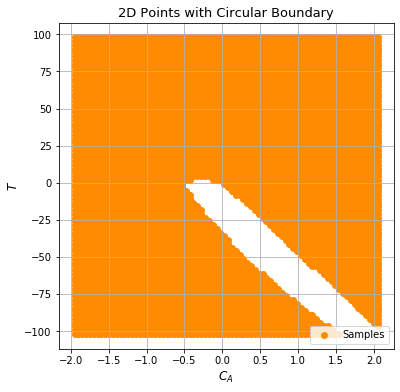

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# Convert to x and y components
x = [v[0] for v in x_initial]
y = [v[1] for v in x_initial]

# Plotting
plt.figure(figsize=(6, 6))
plt.scatter(x, y, color='darkorange', label='Samples')
plt.xlim(-4, 4)  # Set C_A range


# Labels and formatting
plt.xlabel('$C_A$', fontsize=12)
plt.ylabel('$T$', fontsize=12)
plt.grid(True)
plt.legend()
plt.axis('equal')
plt.axis('tight')
plt.title('2D Points with Circular Boundary', fontsize=13)
plt.show()


In [25]:
np.savetxt('dV_benchmark_LSTM.txt', Plot_list, fmt='%.6f')  # value of \dot V for each sample\n"

# Comparision

In [26]:
x1_range = np.linspace(0.0, 6.0, 400, endpoint=True)  #CA
x2_range = np.linspace(300.0, 600.0, 400, endpoint=True)   #T

Total_states = list()
Stable_states = list()
t0 = time.time()
for x10 in x1_range:
    for x20 in x2_range:
        x = np.array([x10-CA1_s,x20-T1_s])
        if x @ P @ x < 372:
            x1 = x10 #real value
            x2 = x20

            #get f1,g11,g12;f2,g21,g22
            my_rawdata = np.array([x1,  x2])
            fx_bar,gx1_bar,gx2_bar = my_ens_prediction(my_rawdata)

            fx1 = (fx_bar[0,0,0]-gx1_bar[0,0,0]*u1_mean/u1_std)*dx1_std + dx1_mean
            gx11 = dx1_std*gx1_bar[0,0,0]/u1_std  #CA


            fx2 = (fx_bar[0,0,1]-gx2_bar[0,0,0]*u2_mean/u2_std)*dx2_std + dx2_mean
            gx22 = dx2_std*gx2_bar[0,0,0]/u2_std  #T


            Lyapunov = a*(x1-CA1_s)*(x1-CA1_s)+2*b*(x2-T1_s)*(x1-CA1_s)+d*(x2-T1_s)*(x2-T1_s)



            LfV1=(2*a*(x1-CA1_s)+2*b*(x2-T1_s))*fx1
            LfV2=(2*d*(x2-T1_s)+2*b*(x1-CA1_s))*fx2

            LfV = LfV1 + LfV2

            LGV1=(2*a*(x1-CA1_s)+2*b*(x2-T1_s))*gx11

            LGV2=(2*d*(x2-T1_s)+2*b*(x1-CA1_s))*gx22

            #LGVnormsquare=(LGV1**2+LGV2**2)  #for all



            kx1=(LfV+np.sqrt(LfV**2+LGV1**4))/LGV1**2
            ub1=-kx1*LGV1

            #kx2=(LfV2+np.sqrt(LfV2**2+umax**4*LGVnormsquare**2))/(np.sqrt(LGVnormsquare)*(np.sqrt(1+umax**2*LGVnormsquare)))
            kx2=(LfV+np.sqrt(LfV**2+LGV2**4))/LGV2**2
            ub2=-kx2*LGV2

    #         u1 = ub1
    #         u2 = ub2
            if (ub1 > 3.5): #CA0
                u1 = 3.5
            elif (ub1 < -3.5):
                u1 = -3.5
            else : 
                u1=ub1


            if ub2 > 5e5: #Q
                u2=5e5
            elif ub2 < -5e5:
                u2=-5e5
            else :
                u2=ub2

            CA1 = x1
            T1 = x2
            fx1 = -F/V*(CA1) - K0*np.exp(-E/(R*(T1)))*CA1
            gx11 = F/V
            fx2 = F*(T_0-T1)/V -Dh/(rho*Cp)*K0*np.exp(-E/(R*(T1)))*CA1
            gx22 = 1/(rho*Cp*V)


            dV=(2*a*(x1-CA1_s)+2*b*(x2-T1_s))*(fx1+u1*gx11)+(2*d*(x2-T1_s)+2*b*(x1-CA1_s))*(fx2+u2*gx22)


            if dV <= -0*0.01*Lyapunov:
                Stable_states.append([x10-CA1_s,x20-T1_s])
            Total_states.append([x10-CA1_s,x20-T1_s])
t1 = time.time()

In [27]:
print(len(Stable_states)) #stable number
print(len(Total_states)) #total number
print(t1-t0)

9305
12603
87.627108335495


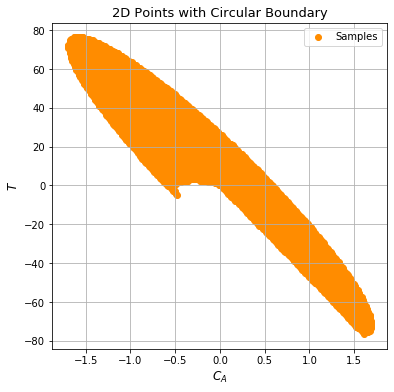

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# Convert to x and y components
x = [v[0] for v in Stable_states]
y = [v[1] for v in Stable_states]

# Plotting
plt.figure(figsize=(6, 6))
plt.scatter(x, y, color='darkorange', label='Samples')
plt.xlim(-4, 4)  # Set C_A range


# Labels and formatting
plt.xlabel('$C_A$', fontsize=12)
plt.ylabel('$T$', fontsize=12)
plt.grid(True)
plt.legend()
plt.axis('equal')
plt.axis('tight')
plt.title('2D Points with Circular Boundary', fontsize=13)
plt.show()